<a href="https://colab.research.google.com/github/LuanLuna12705/dbtest/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Xử lý dữ liệu

In [45]:
import pandas as pd

# 1. Đọc dữ liệu chính - Thêm 'r' trước '\s+' để sửa lỗi SyntaxWarning
df_data = pd.read_csv('data.txt', sep=r'\s+', comment='%', header=None,
                     names=['Station_ID', 'Series', 'Date_Decimal', 'Temp', 'Uncertainty', 'Obs', 'Time_Obs'])

df_sites = pd.read_csv('site_summary.txt', sep=r'\s+', comment='%', header=None,
                       names=['Station_ID', 'Latitude', 'Longitude', 'Elevation'])

# 2. Đọc file đặc tính trạm để lấy Min/Max
# Dựa trên ảnh: Max Value là cột 10, Min Value là cột 11 (tính từ 0)
df_char = pd.read_csv('data_characterization.txt', sep=r'\s+', comment='%', header=None)
df_stats = df_char[[0, 10, 11]].copy()
df_stats.columns = ['Station_ID', 'Max_Value', 'Min_Value']

# 3. Hàm định dạng ngày
def format_date(decimal_year):
    year = int(decimal_year)
    fraction = decimal_year - year
    month = max(1, min(12, round((fraction * 12) + 0.5)))
    return f"{month:02d}/{year}"

# 4. Lọc dữ liệu 2015-2017 và xử lý
df_filtered = df_data[(df_data['Date_Decimal'] >= 2015) & (df_data['Date_Decimal'] < 2018)].copy()
df_filtered['Date_Formatted'] = df_filtered['Date_Decimal'].apply(format_date)

# 5. Gộp các bảng (Merge)
# Gộp với tọa độ
combined_df = pd.merge(df_filtered, df_sites, on='Station_ID', how='left')
# Gộp với giá trị Min/Max từ file characterization
final_df = pd.merge(combined_df, df_stats, on='Station_ID', how='left')

# 6. Chọn các cột hiển thị
final_table = final_df[['Station_ID', 'Date_Formatted', 'Temp', 'Min_Value', 'Max_Value', 'Latitude', 'Longitude']]

# Hiển thị
print("BẢNG DỮ LIỆU TỔNG HỢP CẬP NHẬT MIN/MAX:")
print(final_table.head(10).to_string(index=False))

# ... (tiếp nối phần mã trước đó)

# 7. Lưu bảng thành file CSV
# index=False: Để không lưu cột số thứ tự mặc định của pandas
# encoding='utf-8-sig': Giúp hiển thị tốt tiếng Việt và các ký tự đặc biệt khi mở bằng Excel
final_table.to_csv('du_lieu_tong_hop_2015_2017.csv', index=False, encoding='utf-8-sig')

print("\nĐã lưu file thành công với tên: du_lieu_tong_hop_2015_2017.csv")

BẢNG DỮ LIỆU TỔNG HỢP CẬP NHẬT MIN/MAX:
 Station_ID Date_Formatted  Temp  Min_Value  Max_Value  Latitude  Longitude
      47499        01/2015  -6.7    -22.088      -56.6     -83.1      174.2
      47499        02/2015 -10.7    -22.088      -56.6     -83.1      174.2
      47499        03/2015 -26.3    -22.088      -56.6     -83.1      174.2
      47499        04/2015 -32.3    -22.088      -56.6     -83.1      174.2
      47499        05/2015 -31.4    -22.088      -56.6     -83.1      174.2
      47499        06/2015 -31.8    -22.088      -56.6     -83.1      174.2
      47499        07/2015 -35.3    -22.088      -56.6     -83.1      174.2
      47499        08/2015 -35.1    -22.088      -56.6     -83.1      174.2
      47499        09/2015 -34.9    -22.088      -56.6     -83.1      174.2
      47499        10/2015 -20.4    -22.088      -56.6     -83.1      174.2

Đã lưu file thành công với tên: du_lieu_tong_hop_2015_2017.csv


Figure 2 : *THUẬT TOÁN GREEDY*

Tiêu chí: Biên độ nhiệt (Temp Range)
Tổng trạm: 3011 | Chọn: 90 trạm


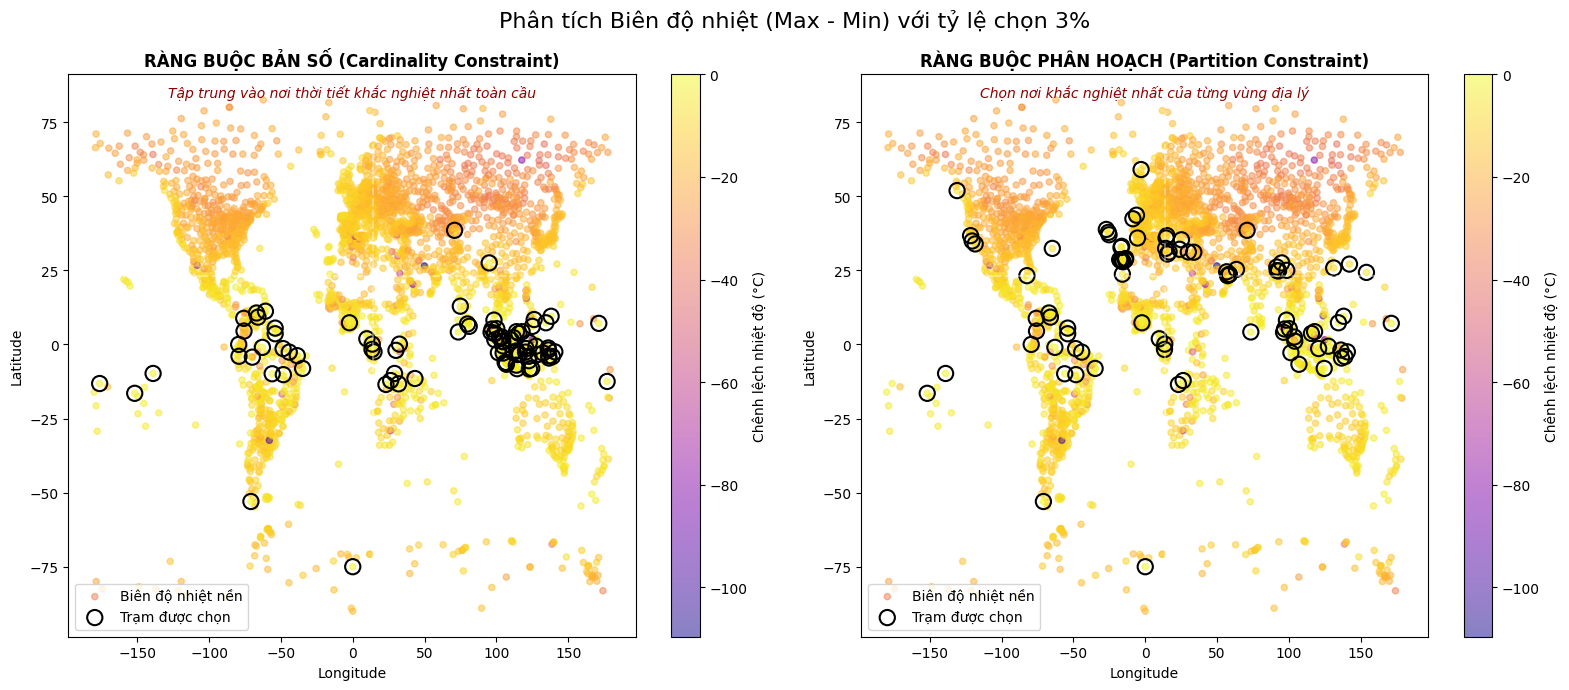

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- BƯỚC 1: XỬ LÝ DỮ LIỆU ---
df_raw = pd.read_csv('du_lieu_tong_hop_2015_2017.csv')

# Gộp dữ liệu theo trạm
# Tính Max thực tế và Min thực tế của từng trạm trong suốt giai đoạn đo
df = df_raw.groupby(['Station_ID', 'Latitude', 'Longitude']).agg({
    'Max_Value': 'max',
    'Min_Value': 'min'
}).reset_index()

# TÍNH BIÊN ĐỘ NHIỆT (Chênh lệch Nóng - Lạnh)
df['Temp_Range'] = df['Max_Value'] - df['Min_Value']

# Lấy dữ liệu để vẽ
x = df['Longitude'].values
y = df['Latitude'].values
values = df['Temp_Range'].values  # Đây là giá trị cốt lõi để so sánh
num_points = len(df)

# Chọn 3% dữ liệu
k = int(num_points * 0.03)
if k < 1: k = 1

print(f"Tiêu chí: Biên độ nhiệt (Temp Range)")
print(f"Tổng trạm: {num_points} | Chọn: {k} trạm")

# --- BƯỚC 2: THUẬT TOÁN GREEDY ---

# 1. Ràng buộc Bản số (Cardinality Constraint)
# Chọn k trạm có biên độ nhiệt lớn nhất TOÀN CẦU
idx_cardinality = np.argsort(values)[::-1][:k]

# 2. Ràng buộc Phân hoạch (Partition Constraint)
# Chia 4 vùng, chọn trạm có biên độ lớn nhất CỦA TỪNG VÙNG
avg_x, avg_y = np.mean(x), np.mean(y)
zones = {'DongBac': [], 'TayBac': [], 'DongNam': [], 'TayNam': []}

for i in range(num_points):
    if x[i] >= avg_x and y[i] >= avg_y: zones['DongBac'].append(i)
    elif x[i] < avg_x and y[i] >= avg_y: zones['TayBac'].append(i)
    elif x[i] < avg_x and y[i] < avg_y: zones['TayNam'].append(i)
    else: zones['DongNam'].append(i)

limit_per_zone = int(k / 4) + 1
idx_partition = []

for indices in zones.values():
    # Lấy giá trị (Range) của các trạm trong vùng
    z_vals = [(values[i], i) for i in indices]
    # Sắp xếp giảm dần (Biên độ lớn nhất lên đầu)
    z_vals.sort(key=lambda pair: pair[0], reverse=True)
    # Chọn top
    selected = [idx for val, idx in z_vals[:limit_per_zone]]
    idx_partition.extend(selected)

idx_partition = idx_partition[:k]

# --- BƯỚC 3: VẼ ĐỒ THỊ ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

def plot_range_map(ax, selected_idx, title, subtitle):
    # Vẽ nền: Màu càng sáng (vàng/cam) là biên độ nhiệt càng lớn, màu tối là ổn định
    # Dùng colormap 'plasma' hoặc 'inferno' để thể hiện độ mạnh
    sc = ax.scatter(x, y, c=values, cmap='plasma', s=20, alpha=0.5, label='Biên độ nhiệt nền')

    # Vẽ điểm được chọn
    ax.scatter(x[selected_idx], y[selected_idx],
               s=120, facecolors='none', edgecolors='black', linewidth=1.5,
               label='Trạm được chọn')

    # Vẽ trục chia vùng
    ax.axvline(avg_x, color='white', linestyle='--', alpha=0.4)
    ax.axhline(avg_y, color='white', linestyle='--', alpha=0.4)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.text(0.5, 0.96, subtitle, transform=ax.transAxes, ha='center', fontsize=10, style='italic', color='darkred')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(sc, ax=ax, label="Chênh lệch nhiệt độ (°C)")
    ax.legend(loc='lower left')

# Vẽ hình 1: Cardinality
plot_range_map(axes[0], idx_cardinality,
               "RÀNG BUỘC BẢN SỐ (Cardinality Constraint)",
               "Tập trung vào nơi thời tiết khắc nghiệt nhất toàn cầu")

# Vẽ hình 2: Partition
plot_range_map(axes[1], idx_partition,
               "RÀNG BUỘC PHÂN HOẠCH (Partition Constraint)",
               "Chọn nơi khắc nghiệt nhất của từng vùng địa lý")

plt.suptitle(f"Phân tích Biên độ nhiệt (Max - Min) với tỷ lệ chọn 3%", fontsize=16)
plt.tight_layout()
plt.show()

Figure 3: *3 trạm có phương sai lớn nhất*

Top 3 Station IDs có biến động cao nhất: [51799 51854 51810]


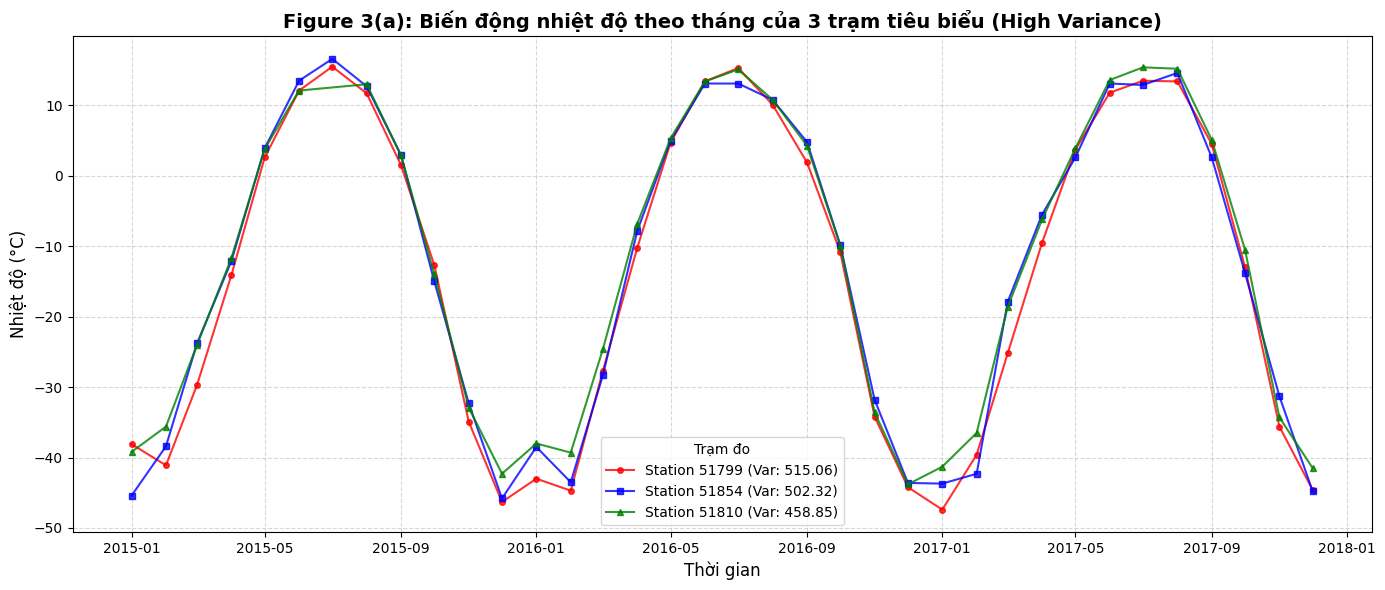

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. ĐỌC DỮ LIỆU
df = pd.read_csv('du_lieu_tong_hop_2015_2017.csv')

# Chuyển đổi cột Date_Formatted sang dạng datetime để vẽ trục thời gian cho đúng
df['Date'] = pd.to_datetime(df['Date_Formatted'], format='%m/%Y')

# 2. TÌM 3 TRẠM CÓ BIẾN ĐỘNG (VARIANCE) CAO NHẤT
# Bài báo gốc dùng "Variance" (Phương sai) để đo độ biến động
station_stats = df.groupby('Station_ID')['Temp'].var().reset_index()
station_stats.columns = ['Station_ID', 'Variance']

# Lấy Top 3 trạm có phương sai lớn nhất
top_3_stations = station_stats.sort_values(by='Variance', ascending=False).head(3)
top_3_ids = top_3_stations['Station_ID'].values

print("Top 3 Station IDs có biến động cao nhất:", top_3_ids)

# 3. VẼ BIỂU ĐỒ CHUỖI THỜI GIAN (TIME SERIES)
plt.figure(figsize=(14, 6))

colors = ['red', 'blue', 'green']
markers = ['o', 's', '^']

for i, station_id in enumerate(top_3_ids):
    # Lấy dữ liệu của trạm này
    station_data = df[df['Station_ID'] == station_id].sort_values(by='Date')

    # Vẽ đường
    plt.plot(station_data['Date'], station_data['Temp'],
             label=f'Station {int(station_id)} (Var: {top_3_stations.iloc[i]["Variance"]:.2f})',
             color=colors[i], marker=markers[i], markersize=4, linewidth=1.5, alpha=0.8)

# Trang trí biểu đồ giống phong cách bài báo
plt.title('Figure 3(a): Biến động nhiệt độ theo tháng của 3 trạm tiêu biểu (High Variance)', fontsize=14, fontweight='bold')
plt.ylabel('Nhiệt độ (°C)', fontsize=12)
plt.xlabel('Thời gian', fontsize=12)
plt.legend(title='Trạm đo', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Đang xử lý dữ liệu...


/tmp/ipython-input-621796431.py:15: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Đang chạy thuật toán (có thể mất vài giây)...


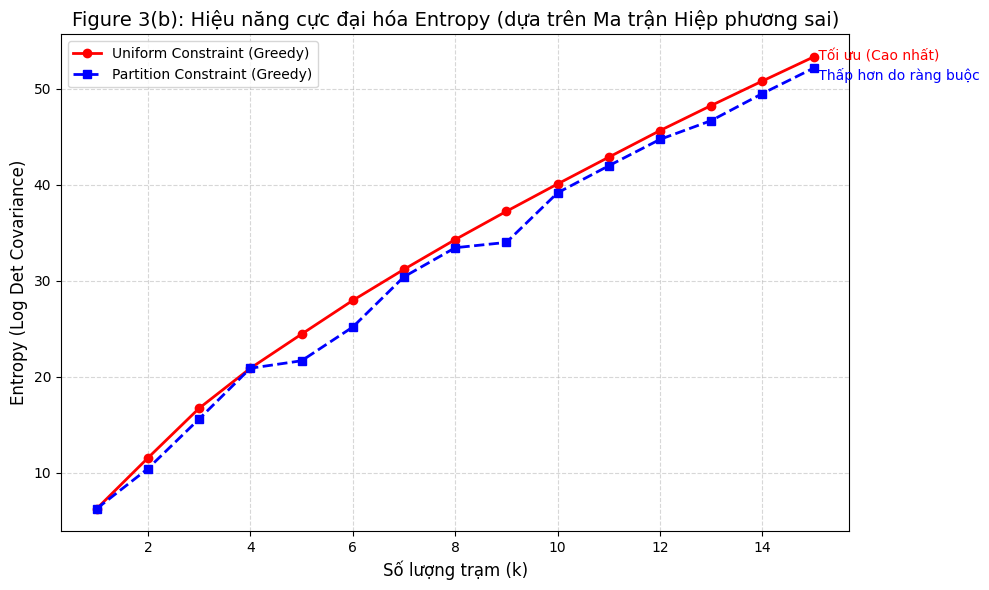

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU TIME-SERIES ---
print("Đang xử lý dữ liệu...")
df = pd.read_csv('du_lieu_tong_hop_2015_2017.csv')

# Tạo bảng Pivot: Hàng là Thời gian, Cột là Station_ID
# Để tính toán hiệp phương sai giữa các trạm với nhau
pivot_df = df.pivot_table(index='Date_Formatted', columns='Station_ID', values='Temp')

# Xử lý dữ liệu thiếu: Điền bằng phương pháp nội suy hoặc loại bỏ cột thiếu quá nhiều
pivot_df = pivot_df.dropna(axis=1, thresh=int(len(pivot_df)*0.8)) # Giữ trạm có ít nhất 80% dữ liệu
pivot_df = pivot_df.fillna(method='ffill').fillna(method='bfill') # Lấp đầy lỗ hổng còn lại

# Tính MA TRẬN HIỆP PHƯƠNG SAI (Covariance Matrix) - Kích thước N x N
# Đây là Σ trong bài báo
cov_matrix = pivot_df.cov()
all_stations = cov_matrix.columns.values
n_total = len(all_stations)

# Lấy tọa độ để dùng cho Constraint Partition
coord_df = df[['Station_ID', 'Latitude', 'Longitude']].drop_duplicates('Station_ID').set_index('Station_ID')
coords = coord_df.loc[all_stations] # Đảm bảo thứ tự khớp với ma trận cov

# --- BƯỚC 2: HÀM TÍNH ENTROPY (HÀM MỤC TIÊU) ---
def calculate_entropy(selected_indices):
    """
    Tính Entropy f(S) = log det(Σ_S)
    """
    if len(selected_indices) == 0: return 0

    # Lấy ma trận con tương ứng với các trạm được chọn
    sub_matrix = cov_matrix.iloc[selected_indices, selected_indices].values

    # Tính Log Determinant (Dùng slogdet để tránh tràn số học)
    sign, logdet = np.linalg.slogdet(sub_matrix)

    if sign <= 0: return -np.inf # Trường hợp ma trận không xác định dương
    return logdet

# --- BƯỚC 3: THUẬT TOÁN GREEDY (Uniform & Partition) ---

def greedy_uniform(k):
    """Chọn k trạm làm tăng Entropy nhiều nhất"""
    current_idx = []
    current_val = 0

    # Loop k lần để chọn k trạm
    for _ in range(k):
        best_gain = -np.inf
        best_i = -1

        # Thử thêm từng trạm chưa được chọn
        remaining = [i for i in range(n_total) if i not in current_idx]

        # (Trong thực tế cần tối ưu tốc độ, ở đây code vét cạn để dễ hiểu)
        for i in remaining:
            # Tính entropy nếu thêm trạm i
            new_val = calculate_entropy(current_idx + [i])
            gain = new_val - current_val

            if gain > best_gain:
                best_gain = gain
                best_i = i

        if best_i != -1:
            current_idx.append(best_i)
            current_val = calculate_entropy(current_idx)

    return current_val

def greedy_partition(k):
    """Chia 4 vùng, mỗi vùng buộc chọn k/4 trạm"""
    # 1. Phân vùng các index
    avg_x, avg_y = coords['Longitude'].mean(), coords['Latitude'].mean()
    zones = {'NE': [], 'NW': [], 'SW': [], 'SE': []}

    for i, station_id in enumerate(all_stations):
        lat = coords.loc[station_id, 'Latitude']
        lon = coords.loc[station_id, 'Longitude']
        if lon >= avg_x and lat >= avg_y: zones['NE'].append(i)
        elif lon < avg_x and lat >= avg_y: zones['NW'].append(i)
        elif lon < avg_x and lat < avg_y: zones['SW'].append(i)
        else: zones['SE'].append(i)

    current_idx = []

    # Chia k slot cho 4 vùng
    limit = int(np.ceil(k / 4))

    # Chọn Greedy TRONG TỪNG VÙNG (Local Greedy)
    # Lưu ý: Bài báo gốc có thể dùng thuật toán phức tạp hơn (trao đổi giữa các vùng),
    # nhưng ở đây ta dùng Local Greedy để mô phỏng sự ràng buộc.
    for z in zones:
        zone_candidates = zones[z]
        zone_selected = []

        # Chọn top 'limit' trạm trong vùng này
        for _ in range(limit):
            if len(zone_selected) + len(current_idx) >= k: break
            if not zone_candidates: break

            best_gain = -np.inf
            best_i = -1

            for i in zone_candidates:
                if i not in zone_selected:
                    # Tính gain khi kết hợp với các trạm ĐÃ chọn (của cả các vùng khác)
                    new_val = calculate_entropy(current_idx + zone_selected + [i])
                    # Lưu ý: Tính gain so với tập hiện tại
                    curr_score = calculate_entropy(current_idx + zone_selected)
                    gain = new_val - curr_score

                    if gain > best_gain:
                        best_gain = gain
                        best_i = i

            if best_i != -1:
                zone_selected.append(best_i)

        current_idx.extend(zone_selected)

    return calculate_entropy(current_idx)

# --- BƯỚC 4: CHẠY MÔ PHỎNG VÀ VẼ HÌNH ---
print("Đang chạy thuật toán (có thể mất vài giây)...")

k_values = list(range(1, 16)) # Chạy thử k từ 1 đến 15 (Tính determinant tốn kém nên demo số nhỏ)

y_uniform = []
y_partition = []

for k in k_values:
    y_uniform.append(greedy_uniform(k))
    y_partition.append(greedy_partition(k))

# Vẽ đồ thị
plt.figure(figsize=(10, 6))

plt.plot(k_values, y_uniform, 'r-o', label='Uniform Constraint (Greedy)', linewidth=2)
plt.plot(k_values, y_partition, 'b--s', label='Partition Constraint (Greedy)', linewidth=2)

plt.title('Figure 3(b): Hiệu năng cực đại hóa Entropy (dựa trên Ma trận Hiệp phương sai)', fontsize=14)
plt.xlabel('Số lượng trạm (k)', fontsize=12)
plt.ylabel('Entropy (Log Det Covariance)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Highlight nhận xét
plt.text(k_values[-1], y_uniform[-1], ' Tối ưu (Cao nhất)', color='red', va='center')
plt.text(k_values[-1], y_partition[-1], ' Thấp hơn do ràng buộc', color='blue', va='top')

plt.tight_layout()
plt.show()